In [ ]:
import requests
import os
import math
import time
from urllib.parse import unquote
import json
import datetime as dt
import pandas as pd
import numpy as np
import copy
from collections import Counter
import matplotlib.pyplot as plt

token = "58c87951560742a3ae7ea9d3d42ca0c30b6980bc"
headers = {'Authorization': f'token {token}', 'Accept': 'application/vnd.github.mercy-preview+json'}
base_url = f"https://api.github.com/"
# r = requests.get(f"{base_url}search/repositories", headers=headers, params=params)

"""Params of the form....params = {
    'q': 'javascript-game',
    'sort': 'stars',
    'per_page': '100'
}"""

tags = [
      'browser-extension',
      'chrome-extension',
      'firefox-extension',
      'firefox-addon',
      'web-extension'  
]

max_pages_by_keyword = {
    'browser-extension': 12,
    'chrome-extension': 94,
    'firefox-extension': 11,
    'firefox-addon': 14,
    'web-extension': 3
}


In [ ]:
dt.datetime(2020, 1, 1).isoformat()

'2020-01-01T00:00:00'

In [ ]:
def getReposByTag(tag):
  """ Get total count and decide based on if number of results >1000 """
  numberOfResults = getTotalCount("topic:" + tag)
  print(f"{tag}...count = {numberOfResults}")

  """ If repos between 1000 and 5000 use yearly results """
  if(numberOfResults > 1000 and numberOfResults < 5000):
    repos = []
    """ Use 1 year slots """
    for year in range(2008, 2022):
      query = f"topic:{tag}+created:{dt.datetime(year, 1, 1).isoformat()}..{dt.datetime(year, 12, 31).isoformat()}"
      """ Get count -> Get # of pages -> Make the request """
      total_count = getTotalCount(query)
      pages = math.ceil(total_count/100)
      repos = repos + scrapeRepos(query, pages)
    return repos

  """ If repos > 5000 use 6 month results """
  if(numberOfResults >= 5000):
    repos = []
    """ Use four quarters """
    for year in range(2008, 2022):
      query_first_q = f"topic:{tag}+created:{dt.datetime(year, 1, 1).isoformat()}..{dt.datetime(year, 3, 31).isoformat()}"
      query_second_q = f"topic:{tag}+created:{dt.datetime(year, 4, 1).isoformat()}..{dt.datetime(year, 6, 30).isoformat()}"
      query_third_q = f"topic:{tag}+created:{dt.datetime(year, 7, 1).isoformat()}..{dt.datetime(year, 9, 30).isoformat()}"
      query_fourth_q = f"topic:{tag}+created:{dt.datetime(year, 10, 1).isoformat()}..{dt.datetime(year, 12, 31).isoformat()}"

      """ Get count -> Get # of pages -> Make the request (For all four quarters)"""
      total_count = getTotalCount(query_first_q)
      pages = math.ceil(total_count/100)
      q1 = scrapeRepos(query_first_q, pages)

      total_count = getTotalCount(query_second_q)
      pages = math.ceil(total_count/100)
      q2 = scrapeRepos(query_second_q, pages)

      total_count = getTotalCount(query_third_q)
      pages = math.ceil(total_count/100)
      q3 = scrapeRepos(query_third_q, pages)

      total_count = getTotalCount(query_fourth_q)
      pages = math.ceil(total_count/100)
      q4 = scrapeRepos(query_fourth_q, pages)

      """ Merge results of both halves """
      repos = repos + q1 + q2 + q3 + q4
    return repos
  else: 
    """ Get count -> Get # of pages -> Make the request """
    total_count = getTotalCount(f"topic:{tag}")
    pages = math.ceil(total_count/100)
    return scrapeRepos(tag, pages)


In [ ]:
""" Get total count of results by query """
def getTotalCount(query):
  print(query)
  try:
    r = requests.get(f"{base_url}search/repositories", headers=headers, params = f'q={query}')
    total_count = json.loads(r.text)['total_count']
    if(not total_count):
      print(f"URL = {r.url}")
      print(json.loads(r.text))
    print(f"repos found --> {total_count}" )
    return total_count
  except:
    print("Failed. Retry after 60 seconds")
    time.sleep(60)
    return getTotalCount(query)
  # pages = math.ceil(total_count/100)

In [ ]:
""" Scrape repos and return them """
def scrapeRepos(query, pages):
  # print(f"Scraping...{query}...{pages}")
  repos = []
  page = 0
  retries = 0
  while(page < pages):
    try:
      r = requests.get(f"{base_url}search/repositories", headers=headers, params = f"q={query}&sort=stars&per_page=100&page={page+1}")
      print(f"url {r.url}")
      data = json.loads(r.text)
      repos = repos + data['items']
      print(f"scraped {len(repos)} repos")
      page = page +1
      retries = 0
    except:
      if(retries > 3):
        print("failed 3 consecutive tries..ABORT")
        page = pages
      else: 
        print(f"failed for page # {page}. Retrying after 60 seconds")
        time.sleep(60)
      retries = retries + 1

      # r = requests.get(f"{base_url}search/repositories", headers=headers, params = f"q={query}&sort=stars&per_page=100&page={page+1}")
      # print(f"url {r.url}")
      # data = json.loads(r.text)
      # repos = repos + data['items']
      # print(f"scraped {len(repos)} repos")

  return repos

### Extract data and save them in appropriate variables

In [ ]:
firefox_extension = getReposByTag('firefox-extension')

In [ ]:
firefox_addon = getReposByTag('firefox-addon')

In [ ]:
safari_extension = getReposByTag('safari-extension')

In [ ]:
chrome_extension = getReposByTag('chrome-extension')

In [ ]:
browser_extension = getReposByTag('browser-extension')

In [ ]:
web_extension = getReposByTag('web-extension')

In [ ]:
opera_extension = getReposByTag('opera-extension')

In [ ]:
edge_extension = getReposByTag('edge-extension')

### Pickle the data for later use

In [ ]:
import pandas as pd
df = pd.DataFrame(edge_extension)
df.to_pickle('edge_extension.pkl') # do this for all variables

### Merge firefox tables to form a consolidated set

In [ ]:
# Essential columns
essential_columns = ['id', 'name', 'html_url', 'description', 'created_at', 'updated_at', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'forks_count', 'open_issues_count', 'archived', 'topics']
# Merge Firefox tables
import pandas as pd
ffe = pd.read_pickle('firefox_extension.pkl')
ffa = pd.read_pickle('firefox_addon.pkl')
ffe_df = ffe[essential_columns]
ffa_df = ffa[essential_columns]
ff_df = pd.concat([ffe_df, ffa_df])
ff_df.drop_duplicates(subset=['id'], inplace=True)

In [ ]:
ffa.shape, ffe.shape, ff_df.shape

((1379, 76), (1133, 76), (2043, 15))

In [ ]:
ff_df.to_pickle('firefox.pkl') # Pickle for later use

### Get consolidated list of other extensions

In [ ]:
browser_extension = pd.read_pickle('browser_extension.pkl')
edge_extension = pd.read_pickle('edge_extension.pkl')
opera_extension = pd.read_pickle('opera_extension.pkl')
web_extension = pd.read_pickle('web_extension.pkl')
chrome_extension = pd.read_pickle('chrome_extension.pkl')
firefox_extension = pd.read_pickle('firefox.pkl')
safari_extension = pd.read_pickle('safari_extension.pkl')

In [ ]:
be_df = browser_extension[essential_columns]
ee_df = edge_extension[essential_columns]
oe_df = opera_extension[essential_columns]
we_df = web_extension[essential_columns]
ce_df = chrome_extension[essential_columns]
ff_df = firefox_extension[essential_columns]
se_df = safari_extension[essential_columns]

### A few exploratory analysis

In [ ]:
be_all_topics = be_df['topics'].tolist()
# for key in be_df['topics']:
#   be_df['topics'][key]

In [ ]:
be_all_topics_flat = [topic for t in be_all_topics for topic in t]

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
all_topics_kv = Counter(be_all_topics_flat)

In [ ]:
all_topics_relevant = {k:v for k, v in all_topics_kv.items() if useful(k)}

In [ ]:
def useful(s):
  return any(substring in s for substring in ['chrome', 'safari', 'firefox', 'edge', 'opera'])

In [ ]:
all_topics_relevant.keys()

dict_keys(['chrome', 'chrome-extension', 'firefox-addon', 'firefox-extension', 'opera-extension', 'opera12', 'google-chrome', 'firefox', 'safari-extension', 'mozilla-firefox', 'mozilla-firefox-addon', 'edge', 'opera', 'safari', 'chrome-app', 'chrome-browser', 'chrome-extensions', 'chrome-plugin', 'firefox-browser', 'edge-extension', 'microsoft-edge', 'firefox-webextension', 'chrome-browser-extension', 'extension-chrome', 'firefox-extensions', 'chrome-addon', 'edge-addon', 'msedge-extension', 'firefox-shortcut-keys', 'firefox-quantum', 'chrome-extension-seed', 'chrome-extension-starter', 'google-chrome-extension', 'chrome-extension-react', 'opera-addon', 'chrome-web-store', 'chrome-webstore', 'safari-app-extension', 'personal-knowledge-base', 'add-ons-for-firefox', 'chrome-devtools', 'chromeextension', 'chrome-api', 'chrome-extension-starter-template', 'preact-chrome-extension', 'react-chrome-extension', 'ms-edge', 'firefox-android', 'chrome-smartbox', 'chrome-development', 'mozilla-fir

### Merge all browsers

In [ ]:
df = pd.concat([be_df, we_df, ff_df, ce_df, oe_df, se_df])

In [ ]:
df.shape

(13189, 15)

In [ ]:
df_nodupes = df.drop_duplicates(subset=['id'])

In [ ]:
df_nodupes.head()

NameError: ignored

In [ ]:
df_nodupes.to_pickle('all_dataset.pkl')

### Number of browsers per extension by year

In [ ]:
df =pd.read_csv('browser_extension.csv')
df_sorted_by_date = df.sort_values('created_at')
df_sorted_by_date.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df_sorted_by_date.shape

(11267, 16)

In [ ]:
""" DROP ALL ROWS WITH NO TOPICS. SAVE THAT SET. GET THE COUNT OF ROWS"""
df_sorted_by_date = df_sorted_by_date.loc[df_sorted_by_date['topics'] != '[]']
df_sorted_by_date.shape

(10879, 16)

In [ ]:
# Attach a date column to the dataframe
df_sorted_by_date['year'] = df_sorted_by_date['created_at'].str.split('-').str[0]

In [ ]:
Counter(df_sorted_by_date['year'])

In [ ]:
df_sorted_by_date.loc[df_sorted_by_date.year.apply(lambda x: x == '2021')]

In [ ]:
def updateCount(topicString, countDict):
  if 'chrome' in topicString.lower():
    countDict['chrome'] = countDict['chrome']+ 1
  if 'firefox' in topicString.lower():
    countDict['firefox'] = countDict['firefox']+ 1
  if 'opera' in topicString.lower():
    countDict['opera'] = countDict['opera']+ 1
  if 'safari' in topicString.lower():
    countDict['safari'] = countDict['safari']+ 1
  if 'edge' in topicString.lower():
    countDict['edge'] = countDict['edge']+ 1


In [ ]:
def getValuesByYear(data, browser):
  values = []
  for key in data:
    values .append(data[key][browser])
  return values

In [ ]:
# List of strings to consider:
# Firefox -> firefox-addon, firefox-extension, [firefox]
# Chrome -> chrome-extension, chrome-addon, [chrome]
# Edge -> edge-addon, edge-extension
# Safari -> safari
# Opera -> opera
# Better split the dataframes by year

boiler = {
    'firefox': 0,
    'chrome': 0,
    'edge': 0,
    'opera': 0,
    'safari': 0
}

data = {}
for key, t in df_sorted_by_date.iterrows():
  if t['year'] not in data:
    data[t['year']] = copy.deepcopy(boiler)
  updateCount(t['topics'], data[t['year']])

In [ ]:
chrome_values = getValuesByYear(data, 'chrome')  
firefox_values = getValuesByYear(data, 'firefox')
safari_values = getValuesByYear(data, 'safari')
opera_values = getValuesByYear(data, 'opera')
edge_values = getValuesByYear(data, 'edge')
years = [int(y) for y in data.keys()]

In [ ]:
other_browsers = [sum(x) for x in zip(safari_values, opera_values, edge_values)]

In [ ]:
# Plot all browsers on a single graph
import matplotlib.pyplot as plt 
import numpy as np 

In [ ]:
x = np.arange(len(years))

In [ ]:
width = 0.3

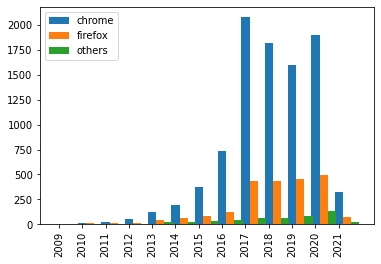

In [ ]:
plt.bar(x, chrome_values, width, label = "chrome")
plt.bar(x + width, firefox_values, width, label = "firefox")
plt.bar(x + 2*width, other_browsers, width, label = "others")
# plt.bar(x + 2*width, opera_values, width, label = "opera")
# plt.bar(x + 3*width, safari_values, width, label = "safari")
# plt.bar(x + 4*width, edge_values, width, label = "edge")
plt.xticks(x, years, rotation ='vertical')
plt.legend()
plt.show()

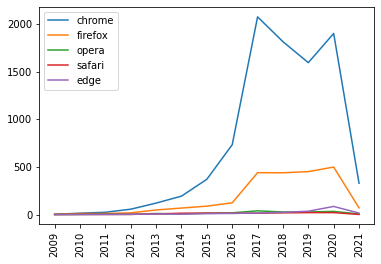

In [ ]:
plt.plot(years, chrome_values, label = "chrome")
plt.plot(years, firefox_values, label = "firefox")
# plt.plt(years, 2*other_browsers, label = "others")
plt.plot(years, opera_values, label = "opera")
plt.plot(years, safari_values, label = "safari")
plt.plot(years, edge_values, label = "edge")
plt.xticks(years, rotation ='vertical')
plt.legend()
plt.show()

In [ ]:
yearwise_data = []

In [ ]:
for y, c, f, s, o, e in zip(years, chrome_values, firefox_values, safari_values, opera_values, edge_values):
  yearwise_data.append({
      'Year': y,
      'Chrome': c,
      'Firefox': f,
      'Safari': s,
      'Opera': o,
      'Edge': e
  })

In [ ]:
pd.DataFrame(yearwise_data).to_csv('yearwise.csv')

Try percentage of Repos next

In [ ]:
chrome_percent = [t[0]*100/(t[0]+t[1]+t[2]+t[3]+t[4]) for t in zip(chrome_values,
                                                               firefox_values, 
                                                               safari_values, 
                                                               edge_values, 
                                                               opera_values)]

In [ ]:
firefox_percent = [t[1]*100/(t[0]+t[1]+t[2]+t[3]+t[4]) for t in zip(chrome_values,
                                                               firefox_values, 
                                                               safari_values, 
                                                               edge_values, 
                                                               opera_values)]

In [ ]:
others_percent = [(t[2] + t[3] + t[4])*100/(t[0]+t[1]+t[2]+t[3]+t[4]) for t in zip(chrome_values,
                                                               firefox_values, 
                                                               safari_values, 
                                                               edge_values, 
                                                               opera_values)]

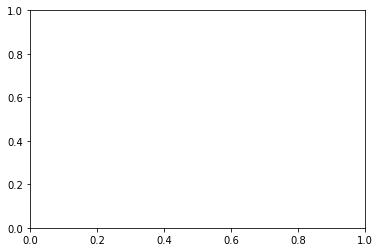

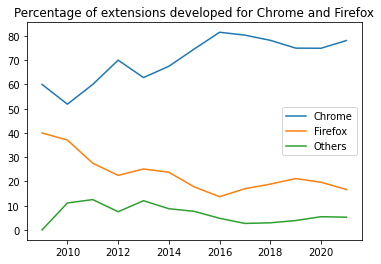

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.plot(years, chrome_percent, label="Chrome")
plt.plot(years, firefox_percent, label="Firefox")
plt.plot(years, others_percent, label="Others")
plt.legend()
plt.title("Percentage of extensions developed for Chrome and Firefox")
for i, v in enumerate(chrome_percent):
    ax.text(i, v+25, "%d" %v, ha="center")
plt.show()

In [ ]:
yearwise_percent = []

In [ ]:
for y, c, f, o in zip(years, chrome_percent, firefox_percent, others_percent):
  yearwise_percent.append({
      'Year': y,
      'Chrome': c,
      'Firefox': f,
      'Others': o
  })

In [ ]:
pd.DataFrame(yearwise_percent).to_csv('yearwise_percent.csv')

### One, Two or more browsers

In [ ]:
data_number_of_browsers = {}
boiler_number_of_browsers = {
   'one': 0,
   'two': 0,
   'moreThanTwo': 0
}

In [ ]:
def updateNumberOfBrowsersCount(data, topics, year):
  count = 0
  topics = topics.lower()
  if 'chrome' in topics:
    count = count + 1
  if 'firefox' in topics:
    count = count + 1
  if 'safari' in topics:
    count = count + 1
  if 'opera' in topics:
    count = count + 1
  if 'edge' in topics:
    count = count + 1
  if count == 1:
    data[year]['one'] = data[year]['one'] + 1
  if count == 2:
    data[year]['two'] = data[year]['two'] + 1
  if count == 3:
    data[year]['moreThanTwo'] = data[year]['moreThanTwo'] + 1

In [ ]:
 for key, t in df_sorted_by_date.iterrows():
  if t['year'] not in data_number_of_browsers:
    data_number_of_browsers[t['year']] = copy.deepcopy(boiler_number_of_browsers)
  updateNumberOfBrowsersCount(data_number_of_browsers, t['topics'], t['year'])

In [ ]:
one_browser = getValuesByYear(data_number_of_browsers, 'one')
two_browser = getValuesByYear(data_number_of_browsers, 'two')
more_browser = getValuesByYear(data_number_of_browsers, 'moreThanTwo')

Data in csv format

In [ ]:
data = []
for o, t, m, y in zip(one_browser, two_browser, more_browser, years):
  data.append({
      'year': y,
      'one_browser': o,
      'two_browsers': t,
      'more_browsers': m,
  })
pd.DataFrame(data).to_csv('number_of_browsers.csv')

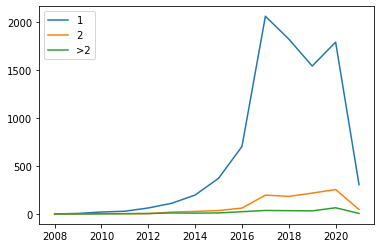

In [ ]:
# Plot values
plt.plot(years, one_browser, label = "1")
plt.plot(years, two_browser, label = "2")
plt.plot(years, more_browser, label = ">2")
# plt.plot(years, safari_values, label = "safari")
# plt.plot(years, edge_values, label = "edge")
plt.legend()
plt.show()

Plot a percentage graph for number of browsers

In [ ]:
percentage_one = [t[0]/(t[0]+t[1]+t[2])*100 for t in zip(one_browser, two_browser, more_browser)]
percentage_two = [t[1]/(t[0]+t[1]+t[2])*100 for t in zip(one_browser, two_browser, more_browser)]
percentage_morethantwo = [t[2]/(t[0]+t[1]+t[2])*100 for t in zip(one_browser, two_browser, more_browser)]

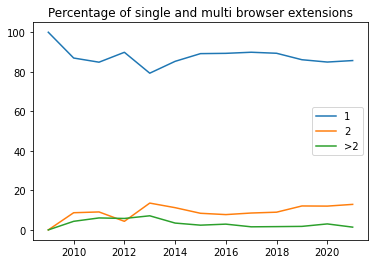

In [ ]:
plt.plot(years, percentage_one, label="1")
plt.plot(years, percentage_two, label="2")
plt.plot(years, percentage_morethantwo, label=">2")
plt.legend()
plt.title('Percentage of single and multi browser extensions')
plt.show()

### Use of Typescript

Exploratory Analysis

In [ ]:
""" Trying to get rid of repos with no topics """

# df_notopics = df_sorted_by_date.loc[df_sorted_by_date['topics'] == '[]']
# Counter(df_notopics['stargazers_count'])
# df_notopics.loc[df_notopics['stargazers_count'] == 3141]
# df_notopics.keys()

' Trying to get rid of repos with no topics '

In [ ]:
Counter(df_sorted_by_date['language'])

Counter({'AutoHotkey': 1,
         'AutoIt': 1,
         'Batchfile': 1,
         'C': 13,
         'C#': 25,
         'C++': 16,
         'CSS': 560,
         'Clojure': 10,
         'CoffeeScript': 21,
         'Dart': 3,
         'Elm': 5,
         'F#': 1,
         'Go': 31,
         'HTML': 557,
         'Haxe': 3,
         'JSON': 1,
         'Java': 24,
         'JavaScript': 8135,
         'Jupyter Notebook': 23,
         'Kotlin': 11,
         'Less': 2,
         'LiveScript': 3,
         'Makefile': 8,
         'Mathematica': 1,
         'NSIS': 1,
         'Nunjucks': 1,
         'OCaml': 7,
         'Objective-C': 4,
         'OpenSCAD': 1,
         'PHP': 22,
         'Perl': 1,
         'PostScript': 1,
         'PureScript': 1,
         'Python': 112,
         'Reason': 2,
         'Ruby': 11,
         'Rust': 5,
         'SCSS': 13,
         'Sass': 2,
         'Scala': 4,
         'Shell': 24,
         'Svelte': 10,
         'Swift': 30,
         'TeX': 2,
         'Tw

In [ ]:
# Get HTML repos and see the secondary language
# Use topic search typescript

In [ ]:
# df_sorted_by_date.loc[df_sorted_by_date['language'] == 'HTML']
str(Counter(df_sorted_by_date['topics']))

In [ ]:
""" Filter by (topic + language) == Typescript 
    Because Typescript might be hidden in HTML/CSS language repos """
contains_ts_topic = df_sorted_by_date['topics'].str.contains("typescript")
df_ts_topic = df_sorted_by_date.loc[contains_ts_topic]

In [ ]:
Counter(df_ts_topic['language'])

Counter({'CSS': 2,
         'HTML': 5,
         'Java': 1,
         'JavaScript': 37,
         'Python': 1,
         'Rust': 2,
         'Sass': 1,
         'TypeScript': 231,
         'Vue': 6,
         nan: 6})

In [ ]:
df_ts_lang = df_sorted_by_date.loc[df_sorted_by_date['language'] == 'TypeScript']

In [ ]:
# Merge ts-topic and ts-lang

df_ts = pd.concat([df_ts_lang, df_ts_topic])
df_ts.shape

(1022, 16)

In [ ]:
# Remove duplicate entries
df_ts.drop_duplicates(['id'], inplace=True)
df_ts.shape

(791, 16)

In [ ]:
# Save the pickle and csv file
df_ts.to_pickle('typescript_extension.pkl')
df_ts.to_csv('typescript.csv')

Next step: Count the number of TypeScript repos as a percentage of all repos. Plot them on a graph

In [ ]:
def countExtensionByYear(data):
  dictionary = {}
  for index, r in data.iterrows():
    if r['year'] not in dictionary:
      dictionary[r['year']] = 1
    else:
      dictionary[r['year']] = dictionary[r['year']] + 1
  return dictionary

In [ ]:
df_ts.shape, df_sorted_by_date.shape

((791, 16), (10879, 16))

In [ ]:
ts_extension_by_year = countExtensionByYear(df_ts)
total_extensions_by_year = countExtensionByYear(df_sorted_by_date)


In [ ]:
ts_line = np.array([0]+[t for t in ts_extension_by_year.values()])
total_line = np.array([t for t in total_extensions_by_year.values()])
ts_percent = [t[0]/t[1]*100 for t in zip(ts_line, total_line)]
years = np.array([int(y) for y in total_extensions_by_year.keys()])

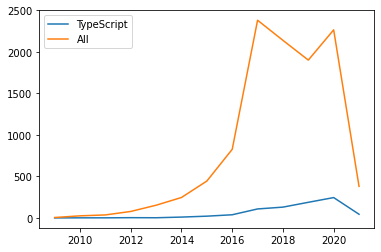

In [ ]:
plt.plot(years, ts_line, label="TypeScript")
plt.plot(years, total_line, label="All")
plt.legend()
plt.show()

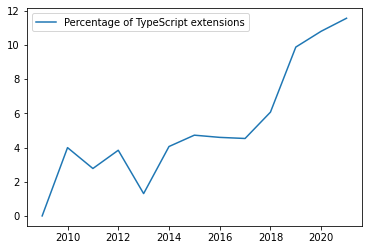

In [ ]:
plt.plot(years, ts_percent, label="Percentage of TypeScript extensions")
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('typescript.csv')

In [ ]:
text_by_y = {}

In [ ]:
for i, j in df.iterrows():
  if j['year'] not in text_by_y:
    text_by_y[j['year']] = 1
  else:
    text_by_y[j['year']] += 1

In [ ]:
text_by_y

{2010: 1,
 2011: 1,
 2012: 3,
 2013: 2,
 2014: 10,
 2015: 21,
 2016: 38,
 2017: 108,
 2018: 130,
 2019: 188,
 2020: 245,
 2021: 44}

In [ ]:
total_extensions_by_year

{'2009': 5,
 '2010': 25,
 '2011': 36,
 '2012': 78,
 '2013': 153,
 '2014': 246,
 '2015': 444,
 '2016': 826,
 '2017': 2381,
 '2018': 2139,
 '2019': 1901,
 '2020': 2265,
 '2021': 380}

### Themes of browser extension projects

In [ ]:
# Use the orginal dataset 
# Remove the repos without topics
# Remove non English descriptions
# Remove punctuations, stopwords, tokenize, lemmatize
# Draw a wordcloud
# Apply LDA

In [ ]:
one_browser, two_browser, more_browser

([0, 10, 22, 28, 62, 111, 197, 371, 703, 2061, 1823, 1542, 1791, 305],
 [0, 0, 2, 3, 3, 19, 26, 35, 61, 196, 183, 217, 254, 46],
 [0, 0, 1, 2, 4, 10, 8, 10, 23, 36, 34, 32, 64, 5])

In [ ]:
df_sorted_by_date

'[]'

In [ ]:
count = 0
for key in df.iterrows():
  count = count +1
print(count)

11267


In [ ]:
len(df_sorted['name'].tolist())

11267

In [ ]:
df_sorted['year']

KeyError: ignored

In [ ]:
len(set(df_sorted['name'].tolist()))

10972

In [ ]:
# Sort by year
indices = []
for index, row in df.iterrows():
  indices.append(index)

len(indices), len(set(indices))

(11267, 7897)

In [ ]:
# Attach a date column to the dataframe
df_sorted['year'] = df['created_at'].str.split('-')[0]

ValueError: ignored

In [ ]:
df_sorted.iloc[1]['created_at'].split('-')[0]

'2008'

In [ ]:
""" Sample data to answer the RQ: 
    {
      2018: {
        total: 
        1:
        2:
        >2:
      }
      2019: {
        total: 
        1:
        2:
        >2:
      }
    }